<a href="https://colab.research.google.com/github/WenquanZou/actor_assistant/blob/master/training_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Preliminary work


## 1.1 Installation

In [ ]:
!pip install transformers
!pip install pytorch-model-summary
!wget https://raw.githubusercontent.com/WenquanZou/actor_assistant/master/data.csv
!wget https://raw.githubusercontent.com/WenquanZou/actor_assistant/master/transitive_verbs.txt

     |████████████████████████████████| 675kB 8.0MB/s 
     |████████████████████████████████| 1.1MB 23.6MB/s 
     |████████████████████████████████| 3.8MB 48.3MB/s 
     |████████████████████████████████| 890kB 62.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=0bf02e7230a80de1bae09c466839b84295e44e3aa6a272fb967dadb063be8c8d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
--2020-06-22 06:34:26--  https://raw.githubusercontent.com/WenquanZou/actor_assistant/master/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16577 (16K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]  16.19K

## 1.2 Import

In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import torchtext
import pytorch_model_summary as pms

## 1.3 GPU work


In [ ]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))

Device: cuda:0
GPU: Tesla P100-PCIE-16GB


#2 Preprocessing


## 2.1 Data collection

In [ ]:
class PlaysDataset(Dataset):
  def __init__(self, texts, annotations, embeddings, annotation_vectors):
    self.samples = []
    for item in zip(texts, annotations, embeddings, annotation_vectors):
      sample = {'text':item[0], 'annotation':item[1], 'embedding':item[2], 'annotation_vector':item[3]}
      self.samples.append(sample)

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, item):
    return self.samples[item]

In [ ]:
# Read the meta data using pandas
import pandas as pd

dataset = pd.read_csv('data.csv')
annotations = dataset["Annotation"]
texts = dataset["Text"]

dataset.head() # show the first five data entries

,Speaker,Text,Annotation,Emotion
0,King Richard,Her life is safest only in her birth.,alert,supporting
1,Marcus Brutus,"Prepare the body then, and follow us",allow,supporting
2,Marcus Brutus,Or else were this a savage spectacle. Our reas...,assure,supporting
3,Mark Antony,"Let each man render me his bloody hand. First,...",capture,supporting
4,King Richard,"Madam, with all my heart",catch,supporting


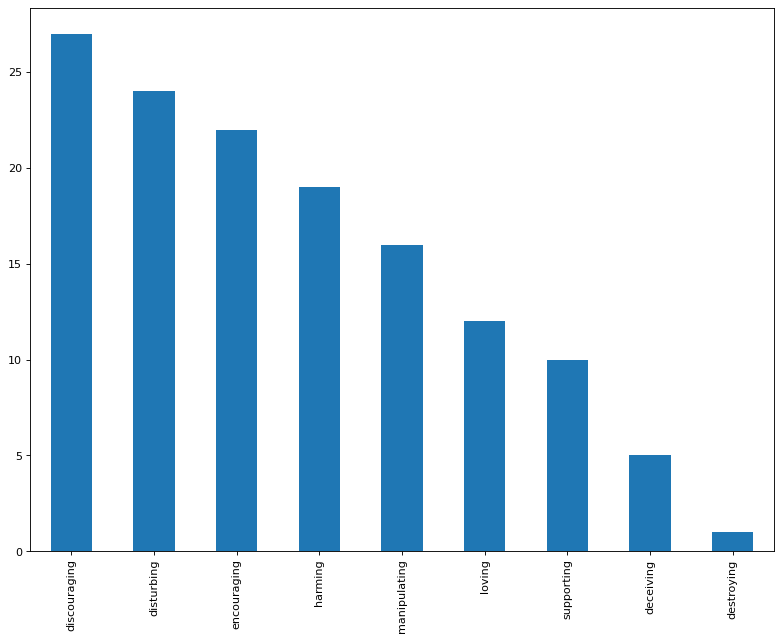

In [ ]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
dataset["Emotion"].value_counts().plot.bar()

In [ ]:
with open("transitive_verbs.txt", "r") as vocabulary:
  action_verbs = vocabulary.read().splitlines()

## 2.2 Parse


In [ ]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Load pre-trained model (weights)
bert_model = BertModel.from_pretrained('bert-base-cased')
bert_model.cuda()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
# Embedding for English when dim 300
glove = torchtext.vocab.GloVe(name='6B', dim=300)

.vector_cache/glove.6B.zip: 862MB [06:25, 2.23MB/s]                           
100%|█████████▉| 399304/400000 [00:48<00:00, 8315.64it/s]

In [ ]:
def get_embedding(text_dataset, is_pad=False, max_length=128):
  inputs = [tokenizer.encode_plus(text_input, add_special_tokens = True, max_length = max_length, pad_to_max_length=is_pad) for text_input in text_dataset]

  input_ids = [d['input_ids'] for d in inputs]
  input_segments = [d['token_type_ids'] for d in inputs]

  # Convert inputs to PyTorch tensors
  tokens_tensor = torch.tensor(input_ids)
  segments_tensor = torch.tensor(input_segments)
  # attention_masks_tensor = torch.tensor(input_attention_masks)
  
  # Predict hidden states features for each layer
  with torch.no_grad():
    last_hidden_states,_ = bert_model(tokens_tensor.to(device), segments_tensor.to(device))


  last_hidden_states = last_hidden_states.cpu().detach().numpy()
  return last_hidden_states

In [ ]:
last_hidden_states = get_embedding(texts, True)
# sentence_embeddings = np.array([np.sum(embedding, axis=0) for embedding in last_hidden_states])
sentence_embeddings = last_hidden_states[:, 0,:]

In [ ]:
last_hidden_states = get_embedding(annotations, True, 8)
# annotation_embeddings = [np.sum(embedding, axis=0) for embedding in last_hidden_states]
annotation_embeddings = last_hidden_states[:, 0, :]
# annotation_embeddings = [glove.vectors[glove.stoi[annotation_input.lower()]] for annotation_input in annotations]

# 3 Implementation of models

In [ ]:
class SimpleCNNForAction(nn.Module):
  def __init__(self, input_size, output_size):
    super(SimpleCNNForAction, self).__init__()
    self.conv1 = nn.Conv1d(1, 1024, kernel_size=3, padding=1)
    self.conv2 = nn.Conv1d(1024, 256, kernel_size=3, padding=1)
    self.drop1 = nn.Dropout(p=0.1)
    self.conv3 = nn.Conv1d(256, output_size, kernel_size=3, padding=1)


  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.drop1(x)
    x = F.relu(self.conv3(x))
    return x


class SingleFeedforwardNN(nn.Module):
  def __init__(self, input_size, output_size, hidden_size):
    super(SingleFeedforwardNN, self).__init__()
    self.layer1 = nn.Linear(input_size, hidden_size)
    self.layer2 = nn.Linear(hidden_size, output_size)
    self.loss = nn.CosineSimilarity(dim=1, eps=1e-6)

  def forward(self, x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    return x

class ActionVerbDecoder(nn.Module):
  def __init__(self, vocabulary):
    super(ActionVerbDecoder, self).__init__()
    # self.vocabulary = [verb for verb in vocabulary]
    self.vocabulary = vocabulary
    self.vocabulary_embeddings = [glove.vectors[glove.stoi[verb.lower()]] for verb in self.vocabulary]
    # self.vocabulary_embeddings = np.array([np.sum(embedding, axis=0) for embedding in get_embedding(self.vocabulary, True, 4)])

  def predict(self, word_vector, text):
    max_similarity = 0
    word_vector = word_vector

    word_vector2 = np.array([np.sum(embedding, axis=0) for embedding in get_embedding([text], True, 128)])
    for index, verb_embedding in enumerate(self.vocabulary_embeddings):
      similarity = cosine(verb_embedding, word_vector)
      if similarity > max_similarity:
        max_similarity = similarity
        result_index = index
        print("max_similarity {:.6f}, verb: {}".format(max_similarity, self.vocabulary[index]))
    return self.vocabulary[index], max_similarity

# 4 Model training

In [ ]:
torch.manual_seed(42) #fix random seed

train_dataset = PlaysDataset(texts[:135], annotations[:135], sentence_embeddings, annotation_embeddings[:135])
val_dataset = PlaysDataset(texts[135:], annotations[135:], sentence_embeddings, annotation_embeddings[135:])
dataloader_train = DataLoader(train_dataset, batch_size=1, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=1, shuffle=True)


START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.364769
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.405059
--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.345623
+ TRAINING 	Epoch: 3 	Loss: 0.371069
+ TRAINING 	Epoch: 4 	Loss: 0.382771
+ TRAINING 	Epoch: 5 	Loss: 0.378787
+ TRAINING 	Epoch: 6 	Loss: 0.373948
+ TRAINING 	Epoch: 7 	Loss: 0.371415
+ TRAINING 	Epoch: 8 	Loss: 0.377033
+ TRAINING 	Epoch: 9 	Loss: 0.393100
+ TRAINING 	Epoch: 10 	Loss: 0.373609
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.395013
--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.368084
+ TRAINING 	Epoch: 12 	Loss: 0.372668
+ TRAINING 	Epoch: 13 	Loss: 0.348167
+ TRAINING 	Epoch: 14 	Loss: 0.365727
+ TRAINING 	Epoch: 15 	Loss: 0.375022
+ TRAINING 	Epoch: 16 	Loss: 0.345061
+ TRAINING 	Epoch: 17 	Loss: 0.407611
+ TRAINING 	Epoch: 18 	Loss: 0.360548
+ TRAINING 	Epoch: 19 	Loss:

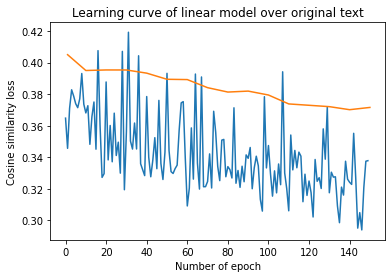

In [ ]:
num_epochs = 150

linear_encoder = SingleFeedforwardNN(768, 768, 600).cuda()
linear_encoder.train()
    
optimizer = torch.optim.Adagrad(linear_encoder.parameters(), lr=0.01)

loss_train_linear_log = []
loss_val_linear_log = []
epoch_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
      embedding = batch_samples['embedding'].to(device)
      annotation_vector = batch_samples['annotation_vector'].to(device)
      optimizer.zero_grad()
      prd = linear_encoder(embedding)
      loss = 1 - linear_encoder.loss(prd, annotation_vector)
      loss = loss.mean()
      loss.backward()
      optimizer.step()

    loss_train_linear_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
 
    # Validation
    if epoch == 1 or epoch % 10 == 0:
      loss_val = 0
      sum_pts = 0
      with torch.no_grad():
        for data_sample in dataloader_val:
          embedding = data_sample['embedding'].to(device)
          annotation_vector = data_sample['annotation_vector'].to(device)
          prd = linear_encoder(embedding)
          loss_val = loss_val + (1 - F.cosine_similarity(prd, annotation_vector))
          sum_pts += 1
      loss_val /= sum_pts

      loss_val_linear_log.append(loss_val.item())
      epoch_val_log.append(epoch)
      print('--------------------------------------------------')
      print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val.item()))
      print('--------------------------------------------------')

plt.title('Learning curve of linear model over original text')
plt.xlabel('Number of epoch')
plt.ylabel('Cosine similarity loss')
plt.plot(range(len(loss_train_linear_log)), loss_train_linear_log)
plt.plot(epoch_val_log, loss_val_linear_log)

In [ ]:
num_epochs = 150

cnn_model = SimpleCNNForAction(768, 300).cuda()
cnn_model.train()
    
optimizer = torch.optim.Adagrad(cnn_model.parameters(), lr=0.01, weight_decay=0.002)

loss_train_cnn_log = []
loss_val_cnn_log = []
epoch_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
      embedding = batch_samples['embedding'].to(device)
      annotation_vector = batch_samples['annotation_vector'].to(device)
      optimizer.zero_grad()
      embedding = embedding.view(1, 1, 768)
      prd = cnn_model(embedding)
      print(prd.shape)
      loss = 1 - F.cosine_similarity(prd, annotation_vector)
      loss = loss.mean()
      loss.backward()
      optimizer.step()

    loss_train_cnn_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

    # Validation
    if epoch == 1 or epoch % 10 == 0:
      loss_val = 0
      sum_pts = 0
      with torch.no_grad():
        for data_sample in dataloader_val:
          embedding = data_sample['embedding'].to(device)
          embedding = embedding.view(1, 1, 768)
          annotation_vector = data_sample['annotation_vector'].to(device)
          prd = cnn_model(embedding)
          loss_val = loss_val + (1 - F.cosine_similarity(prd, annotation_vector))
          loss_val = loss_val.mean()
          sum_pts += 1
      loss_val /= sum_pts

      loss_val_cnn_log.append(loss_val.item())
      epoch_val_log.append(epoch)
      print('--------------------------------------------------')
      print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val.item()))
      print('--------------------------------------------------')

plt.title('Learning curve of CNN model over original text')
plt.xlabel('Number of epoch')
plt.ylabel('Cosine similarity loss')
plt.plot(range(len(loss_train_cnn_log)), loss_train_cnn_log)
plt.plot(epoch_val_log, loss_val_cnn_log)


START TRAINING...
torch.Size([1, 300, 768])


RuntimeError: ignored

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.409719
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.441284
--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.412324
+ TRAINING 	Epoch: 3 	Loss: 0.418561
+ TRAINING 	Epoch: 4 	Loss: 0.409052
+ TRAINING 	Epoch: 5 	Loss: 0.365181
+ TRAINING 	Epoch: 6 	Loss: 0.386259
+ TRAINING 	Epoch: 7 	Loss: 0.395773
+ TRAINING 	Epoch: 8 	Loss: 0.412814
+ TRAINING 	Epoch: 9 	Loss: 0.384117
+ TRAINING 	Epoch: 10 	Loss: 0.381971
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.436430
--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.407420
+ TRAINING 	Epoch: 12 	Loss: 0.380082
+ TRAINING 	Epoch: 13 	Loss: 0.380247
+ TRAINING 	Epoch: 14 	Loss: 0.385583
+ TRAINING 	Epoch: 15 	Loss: 0.362875
+ TRAINING 	Epoch: 16 	Loss: 0.366919
+ TRAINING 	Epoch: 17 	Loss: 0.379081
+ TRAINING 	Epoch: 18 	Loss: 0.384101
+ TRAINING 	Epoch: 19 	Loss:

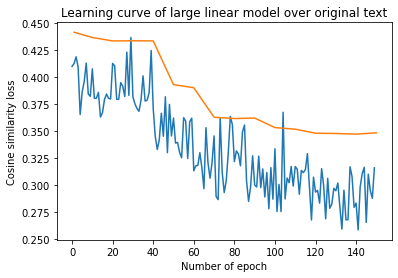

In [ ]:
num_epochs = 150

linear_encoder_large = SingleFeedforwardNN(768, 768, 1600).cuda()
linear_encoder_large.train()
    
optimizer = torch.optim.Adagrad(linear_encoder_large.parameters(), lr=0.01)

loss_train_linear_large_log = []
loss_val_linear_large_log = []
epoch_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
      embedding = batch_samples['embedding'].to(device)
      annotation_vector = batch_samples['annotation_vector'].to(device)
      optimizer.zero_grad()
      prd = linear_encoder_large(embedding)
      loss = 1 - F.cosine_similarity(prd, annotation_vector)
      loss = loss.mean()
      loss.backward()
      optimizer.step()

    loss_train_linear_large_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
 
    # Validation
    if epoch == 1 or epoch % 10 == 0:
      loss_val = 0
      sum_pts = 0
      with torch.no_grad():
        for data_sample in dataloader_val:
          embedding = data_sample['embedding'].to(device)
          annotation_vector = data_sample['annotation_vector'].to(device)
          prd = linear_encoder_large(embedding)
          loss_val = loss_val + (1 - F.cosine_similarity(prd, annotation_vector))
          sum_pts += 1
      loss_val /= sum_pts

      loss_val_linear_large_log.append(loss_val.item())
      epoch_val_log.append(epoch)
      print('--------------------------------------------------')
      print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val.item()))
      print('--------------------------------------------------')

plt.title('Learning curve of large linear model over original text')
plt.xlabel('Number of epoch')
plt.ylabel('Cosine similarity loss')
plt.plot(range(len(loss_train_linear_large_log)), loss_train_linear_large_log)
plt.plot(epoch_val_log, loss_val_linear_large_log)

# 5 Model output
BERT model output a feature can be learn for later fine-tuning, which has (512, 768) dimension for just one sentence embedding.

In [ ]:
from scipy.spatial.distance import cosine

action_decoder = ActionVerbDecoder(action_verbs).cuda()

test_sample1 = train_dataset[2]
test_sample2 = train_dataset[1]

with torch.no_grad():
  transformed1 = linear_encoder(torch.tensor(test_sample1['embedding']).to(device)).cpu().detach().numpy()
  transformed2 = linear_encoder(torch.tensor(test_sample2['embedding']).to(device)).cpu().detach().numpy()

# print(cosine(test_sample1['embedding'], test_sample1['annotation_vector']))
output1, _ =action_decoder.predict(transformed1, train_dataset[1]['annotation'])
output2, _ =action_decoder.predict(transformed2, train_dataset[2]['annotation'])

max_similarity 0.852486, verb: accept
max_similarity 0.905693, verb: aggravate
max_similarity 0.912266, verb: answer
max_similarity 0.969203, verb: beat
max_similarity 1.069572, verb: bend
max_similarity 1.103738, verb: dunk
max_similarity 1.132804, verb: punch
max_similarity 1.139667, verb: ring
max_similarity 0.826254, verb: accept
max_similarity 0.871018, verb: admit
max_similarity 0.906691, verb: bend
max_similarity 0.916900, verb: bless
max_similarity 0.950297, verb: brush
max_similarity 1.013526, verb: comfort
max_similarity 1.084617, verb: edify
max_similarity 1.097336, verb: massage
max_similarity 1.138646, verb: munch


In [ ]:
vector1 = glove.vectors[glove.stoi["challenge"]]
vector2 = glove.vectors[glove.stoi["block"]]
print(vector1)
print(vector2)
print(cosine(vector1, vector2))

tensor([-0.0323,  0.0816,  0.0488, -0.4024,  0.0342,  0.1500,  0.1331, -0.0480,
        -0.0809, -1.0803,  0.6057, -0.5628,  0.3534,  0.3465,  0.1670, -0.3999,
        -0.0340,  0.0426, -0.2165, -0.0036,  0.1957, -0.1594,  0.4211, -0.2582,
        -0.2770, -0.0979,  0.0219,  0.2932, -0.3820, -0.0864,  0.0133, -0.3912,
         0.1655, -0.4005, -1.5610,  0.2442,  0.0696, -0.2534,  0.1117,  0.3003,
         0.4606, -0.0786,  0.4350,  0.2099, -0.2667,  0.2923, -0.1041, -0.2901,
         0.2833, -0.2193, -0.0895, -0.0107, -0.1867,  0.3114,  0.2753,  0.0923,
        -0.1720, -0.0553,  0.2662,  0.3859,  0.1292,  0.2570, -0.5617, -0.0027,
        -0.6135,  0.0339, -0.7355,  0.2602, -0.5002, -0.7228, -0.2788,  0.2341,
        -0.1451, -0.1382,  0.3300, -0.2183, -0.1441, -0.1520, -0.0082,  0.2146,
        -0.4287,  0.0430,  0.4447,  0.0813, -0.3261, -0.3527, -0.0432,  0.4726,
         0.3520,  0.3743, -0.1223, -0.3177,  0.0471, -0.3784,  0.1357, -0.4333,
         0.0736, -0.0809, -0.0072, -0.50

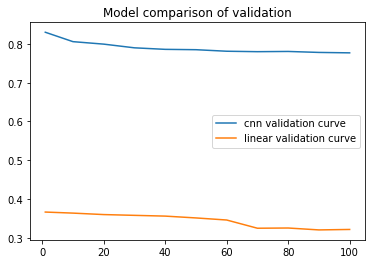

In [ ]:
plt.plot(epoch_val_log, loss_val_cnn_log, label='cnn validation curve')
plt.plot(epoch_val_log, loss_val_linear_log, label='linear validation curve')
plt.title('Model comparison of validation')
plt.legend()
plt.show()

(184, 768)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


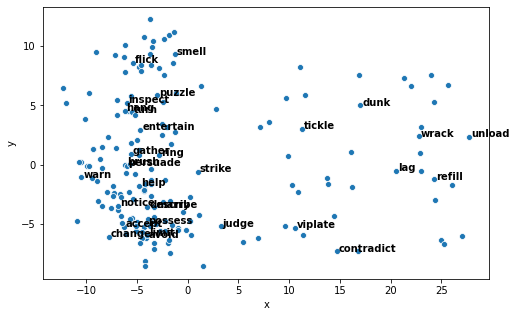

In [ ]:
from sklearn.decomposition import PCA

vocabulary = [verb for verb in action_verbs]
vocabulary_embeddings = np.array([np.sum(embedding, axis=0) for embedding in get_embedding(vocabulary, True, 4)])
print(vocabulary_embeddings.shape)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(vocabulary_embeddings)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['x', 'y'])
principalDf.head
import seaborn as sns
plt.figure(figsize=(8,5))
p1 = sns.scatterplot(
    x="x", y="y",
    palette=sns.color_palette("hls", 10),
    data=principalDf
)

for line in range(0,principalDf.shape[0], 6):
     p1.text(principalDf.x[line]+0.2, principalDf.y[line],
             vocabulary[line], horizontalalignment='left',
             size='medium', color='black', weight='semibold')

In [ ]:
class SingleFeedforwardNN(nn.Module):
  def __init__(self, input_size, output_size, hidden_sizes):
    super(SingleFeedforwardNN, self).__init__()
    self.input_layer = nn.Linear(input_size, hidden_sizes[0])
    self.hidden_layer1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
    
    self.hidden_layer2 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
    # for i in range(1, len(hidden_sizes)):
    #   self.hidden_layer.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i])) 
    self.output_layer = nn.Linear(hidden_sizes[-1], output_size)
    self.loss = nn.CosineSimilarity(dim=1, eps=1e-6)

  def forward(self, x):
    x = F.relu(self.input_layer(x))
    
    x = F.relu(self.hidden_layer1(x))
    x = F.relu(self.hidden_layer2(x))
    x = F.relu(self.output_layer(x))
    return x

In [ ]:
linear_encoder = SingleFeedforwardNN(768, 768, [1536, 1024, 800])
print(pms.summary(linear_encoder, torch.zeros((1, 768))))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1           [1, 1536]       1,181,184       1,181,184
          Linear-2           [1, 1024]       1,573,888       1,573,888
          Linear-3            [1, 800]         820,000         820,000
          Linear-4            [1, 768]         615,168         615,168
Total params: 4,190,240
Trainable params: 4,190,240
Non-trainable params: 0
-----------------------------------------------------------------------


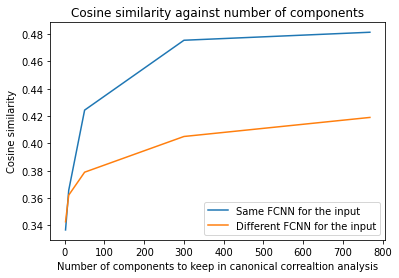

In [ ]:
number_component = [2, 10, 50, 300, 768]

correlation_complex = [0.33673, 0.36571, 0.42437, 0.47548, 0.48134]
correlation_different = [0.34269, 0.36217, 0.37896, 0.40508, 0.41902]


plt.title('Cosine similarity against number of components')
plt.xlabel('Number of components to keep in canonical correaltion analysis')
plt.ylabel('Cosine similarity')
plt.plot(number_component, correlation_complex, label="Same FCNN for the input")
plt.plot(number_component, correlation_different, label="Different FCNN for the input")
plt.legend()
plt.show()

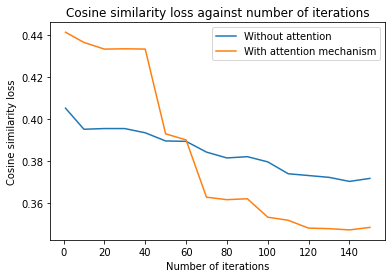

In [ ]:
plt.title('Cosine similarity loss against number of iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Cosine similarity loss')
plt.plot(epoch_val_log, loss_val_linear_log, label="Without attention")
plt.plot(epoch_val_log, loss_val_linear_large_log, label="With attention mechanism")
plt.legend()
plt.show()